# Zero-shot learning

Imagine a scenario where I ask you to predict the class of objects in an image where
you have not seen an image of the object class earlier. How would you make
predictions in such a scenario?

Intuitively, we resort to the attributes of the object in the image and then try to
identify the object that matches the most attributes.

In one such scenario where we have to come up with attributes automatically (where
the attributes are not given for training), we leverage word vectors. Word vectors
encompass semantic similarity among words. For example, all animals would have
similar word vectors and automobiles would have very different word vector
representations. While the generation of word vectors is out of scope for this book, we
will work on pre-trained word vectors. At a very high level, words that have similar
surrounding words (context) will have similar vectors.

From the preceding sample, we can see that the word vectors of automobiles fall to
the left of the chart while the vectors corresponding to animals are on the right.
Further, similar animals also have similar vectors.

This gives us the intuition that words, just like images, also have vector embeddings
that help in obtaining similarity.

In the next section, as we code zero-shot learning, we will leverage this phenomenon
to identify classes that are not seen by the model during training. Essentially, we will
learn about mapping image features to word features, directly.

The high-level strategy we adopt while coding zero-shot learning is as follows:

1. Import the dataset – which constitutes images and their corresponding
classes.

2. Fetch the word vectors corresponding to each class from pre-trained word
vector models.

3. Pass an image through a pre-trained image model such as VGG16.

4. We expect the network to predict the word vector corresponding to the
object in the image.

5. Once we've trained the model, we predict the word vector on new images.

6. The class of word vector that is closest to the predicted word vector is the
class of the image.

In [1]:
!git clone https://github.com/sizhky/zero-shot-learning/
!pip install -Uq torch_snippets
%cd zero-shot-learning/src
import gzip
import _pickle as cPickle
from torch_snippets import *
from sklearn.preprocessing import LabelEncoder, normalize
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Cloning into 'zero-shot-learning'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 102 (delta 20), reused 19 (delta 19), pack-reused 79
Receiving objects: 100% (102/102), 134.47 MiB | 728.00 KiB/s, done.
Resolving deltas: 100% (45/45), done.
/home/lacie/Github/Jellyfish-with-ComputerVision/Theory/Modern-ComputerVision-with-Pytorch/09-Combining-Computer-Vision-with-Other-Techniques/Training-with-Minimal-Data-Points/zero-shot-learning/src


/home/lacie/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
WORD2VECPATH = "../data/class_vectors.npy"
DATAPATH = "../data/zeroshot_data.pkl"

In [3]:
with open('train_classes.txt', 'r') as infile:
    train_classes = [str.strip(line) for line in infile]

In [4]:
with gzip.GzipFile(DATAPATH, 'rb') as infile:
    data = cPickle.load(infile)

In [5]:
training_data = [instance for instance in data if instance[0] in train_classes]
zero_shot_data = [instance for instance in data if instance[0] not in train_classes]
np.random.shuffle(training_data)

In [6]:
train_size = 300 # per class
train_data, valid_data = [], []
for class_label in train_classes:
    ctr = 0
    for instance in training_data:
        if instance[0] == class_label:
            if ctr < train_size:
                train_data.append(instance)
                ctr+=1
            else:
                valid_data.append(instance)

In [7]:
np.random.shuffle(train_data)
np.random.shuffle(valid_data)
vectors = {i:j for i,j in np.load(WORD2VECPATH, allow_pickle=True)}

In [8]:
train_data = [(feat, vectors[clss]) for clss,feat in train_data]
valid_data = [(feat, vectors[clss]) for clss,feat in valid_data]

In [9]:
train_clss = [clss for clss,feat in train_data]
valid_clss = [clss for clss,feat in valid_data]
zero_shot_clss = [clss for clss,feat in zero_shot_data]

In [10]:
x_train, y_train = zip(*train_data)
x_train, y_train = np.squeeze(np.asarray(x_train)), np.squeeze(np.asarray(y_train))
x_train = normalize(x_train, norm='l2')

x_valid, y_valid = zip(*valid_data)
x_valid, y_valid = np.squeeze(np.asarray(x_valid)), np.squeeze(np.asarray(y_valid))
x_valid = normalize(x_valid, norm='l2')

y_zsl, x_zsl = zip(*zero_shot_data)
x_zsl, y_zsl = np.squeeze(np.asarray(x_zsl)), np.squeeze(np.asarray(y_zsl))
x_zsl = normalize(x_zsl, norm='l2')

In [11]:
from torch.utils.data import TensorDataset

trn_ds = TensorDataset(*[torch.Tensor(t).to(device) for t in [x_train, y_train]])
val_ds = TensorDataset(*[torch.Tensor(t).to(device) for t in [x_valid, y_valid]])

trn_dl = DataLoader(trn_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

In [12]:
def build_model(): 
    return nn.Sequential(
        nn.Linear(4096, 1024), nn.ReLU(inplace=True),
        nn.BatchNorm1d(1024), nn.Dropout(0.8),
        nn.Linear(1024, 512), nn.ReLU(inplace=True),
        nn.BatchNorm1d(512), nn.Dropout(0.8),
        nn.Linear(512, 256), nn.ReLU(inplace=True),
        nn.BatchNorm1d(256), nn.Dropout(0.8),
        nn.Linear(256, 300)
    )

In [13]:
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss = criterion(_preds, labels)
    return loss.item()

EPOCH: 10.000  trn_loss: 0.020  val_loss: 0.020  (4.69s - 23.43s remaining)
EPOCH: 20.000  trn_loss: 0.014  val_loss: 0.014  (8.41s - 16.82s remaining)
EPOCH: 30.000  trn_loss: 0.013  val_loss: 0.014  (12.15s - 12.15s remaining)
EPOCH: 40.000  trn_loss: 0.012  val_loss: 0.013  (15.88s - 7.94s remaining)
EPOCH: 50.000  trn_loss: 0.011  val_loss: 0.013  (19.67s - 3.93s remaining)
EPOCH: 60.000  trn_loss: 0.011  val_loss: 0.013  (23.36s - 0.00s remaining)


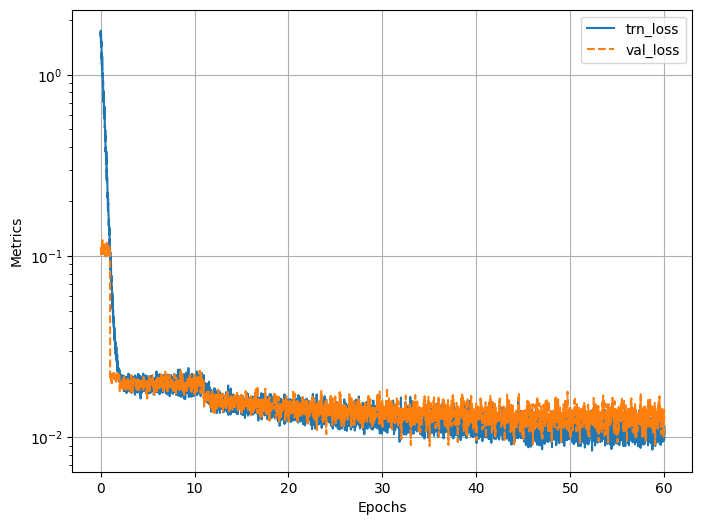

In [14]:
model = build_model().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 60

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, end='\r')
        
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)
    if ex == 40: optimizer = optim.Adam(model.parameters(), lr=1e-5)
    if not (ex+1)%10: log.report_avgs(ex+1)

log.plot(log=True)

In [15]:
pred_zsl = model(torch.Tensor(x_zsl).to(device)).cpu().detach().numpy()

class_vectors = sorted(np.load(WORD2VECPATH, allow_pickle=True), key=lambda x: x[0])
classnames, vectors = zip(*class_vectors)
classnames = list(classnames)

vectors = np.array(vectors)

In [16]:
dists = (pred_zsl[None] - vectors[:,None])
dists = (dists**2).sum(-1).T

best_classes = []
for item in dists:
    best_classes.append([classnames[j] for j in np.argsort(item)[:5]])

np.mean([i in J for i,J in zip(zero_shot_clss, best_classes)])

0.7208604302151076